In [70]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

In [71]:
import pandas as pd
import sklearn

from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse

data = pd.read_csv('/Users/gunnep/Downloads/corona_full_data.csv', parse_dates=['date'], index_col='date')
data.reset_index(inplace=True)

print(data.head(2))


        date     location  new_cases  new_deaths  total_cases  total_deaths
0 2019-12-31  Afghanistan          0           0            0             0
1 2020-01-01  Afghanistan          0           0            0             0


In [72]:
Italy = pd.DataFrame(data[data['location']=='Italy'])

In [73]:
Germany = pd.DataFrame(data[data['location']=='Germany'])

In [74]:
print(Italy)

           date location  new_cases  new_deaths  total_cases  total_deaths
2993 2019-12-31    Italy          0           0            0             0
2994 2020-01-01    Italy          0           0            0             0
2995 2020-01-02    Italy          0           0            0             0
2996 2020-01-03    Italy          0           0            0             0
2997 2020-01-04    Italy          0           0            0             0
...         ...      ...        ...         ...          ...           ...
3071 2020-03-18    Italy       3526         347        31506          2505
3072 2020-03-19    Italy       4207         473        35713          2978
3073 2020-03-20    Italy       5322         429        41035          3407
3074 2020-03-21    Italy       5986         625        47021          4032
3075 2020-03-22    Italy       6557         795        53578          4827

[83 rows x 6 columns]


In [75]:
China = pd.DataFrame(data[data['location']=='China'])

In [76]:
Korea = pd.DataFrame(data[data['location']=='South Korea'])

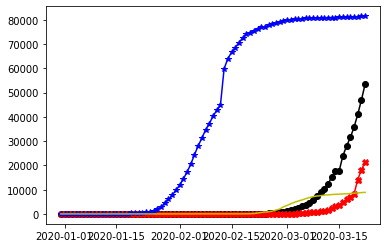

In [77]:
import matplotlib.pyplot as plt

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

plt.plot(Italy['date'],Italy['total_cases'], color='k',marker='o')
plt.plot(Germany['date'],Germany['total_cases'], color='r',marker='X')
plt.plot(China['date'],China['total_cases'], color='b',marker='*')
plt.plot(Korea['date'],Korea['total_cases'], color='y')

In [78]:
#Let's try to fit the two curves
from scipy import optimize

def exp_func(x, a, b, c):
    return a * np.exp(b * x) + c

x_data = np.linspace(0, len(Italy), num=len(Italy))

params_exp, params_covariance_exp = optimize.curve_fit(exp_func, x_data,Italy['total_cases'],
                                               p0=[0.1, 0.1, 0.1])

print(params_exp)
print(params_covariance_exp)

[ 2.62873877e-01  1.47710487e-01 -2.60858575e+02]
[[ 1.56518006e-03 -7.36112823e-05 -1.47306937e+00]
 [-7.36112823e-05  3.46779480e-06  6.71313673e-02]
 [-1.47306937e+00  6.71313673e-02  6.75030369e+03]]


In [79]:
def log_func(x, a, b, c):
    return a / (1 + np.exp(c*(x + b)))

params_log, params_covariance_log = optimize.curve_fit(log_func, x_data,Italy['total_cases'],
                                               p0=[0.1, 0.1, 0.1])

print(params_log)
print(params_covariance_log)

[ 1.26862303e+05 -8.47454827e+01 -1.90445958e-01]
[[ 6.80475710e+07 -4.81156711e+03  2.84429633e+01]
 [-4.81156711e+03  3.42514179e-01 -2.06719092e-03]
 [ 2.84429633e+01 -2.06719092e-03  1.38212316e-05]]


/Users/gunnep/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


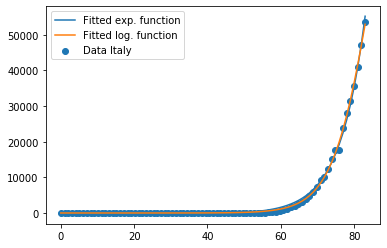

In [80]:
plt.figure(figsize=(6, 4))
plt.scatter(x_data, Italy['total_cases'], label='Data Italy')
plt.plot(x_data, exp_func(x_data, params_exp[0], params_exp[1], params_exp[2]),
         label='Fitted exp. function')

plt.plot(x_data, log_func(x_data, params_log[0], params_log[1], params_log[2]),
         label='Fitted log. function')

plt.legend(loc='best')


In [81]:
#predictions of the new day
#Pessimistic
print(exp_func(len(Italy)+1, params_exp[0], params_exp[1], params_exp[2])-exp_func(len(Italy), params_exp[0], params_exp[1], params_exp[2]))
#Optimistic
print(log_func(len(Italy)+1, params_log[0], params_log[1], params_log[2])-log_func(len(Italy), params_log[0], params_log[1], params_log[2]))

8832.13977192725
5951.627140830518


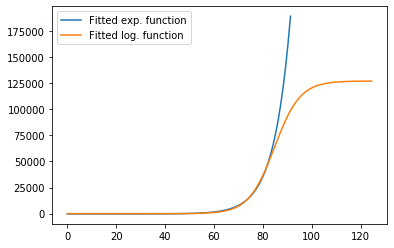

In [82]:
#Plot of the future
x_data = np.linspace(0, len(Italy)*1.1, num=len(Italy)*1.1)

plt.plot(x_data, exp_func(x_data, params_exp[0], params_exp[1], params_exp[2]),
         label='Fitted exp. function')

x_data = np.linspace(0, len(Italy)*1.5, num=len(Italy)*1.5)

plt.plot(x_data, log_func(x_data, params_log[0], params_log[1], params_log[2]),
         label='Fitted log. function')

plt.legend(loc='best')

In [94]:
#build inputs for RNN
x_inputs = []
y_inputs = []
indices = list(Italy.index)

for i in range(len(indices)-1):
    if(i+5<(len(indices)-1)):
        if(Italy.iloc[i+5]['total_cases']>0):
            x_inputs.append([[Italy.iloc[i]['total_cases']],[Italy.iloc[i+1]['total_cases']],[Italy.iloc[i+2]['total_cases']],[Italy.iloc[i+3]['total_cases']],[Italy.iloc[i+4]['total_cases']]])
            y_inputs.append(Italy.iloc[i+5]['total_cases'])
        
x_inputs = np.asarray(x_inputs)
y_inputs = np.asarray(y_inputs)

In [99]:
x_inputs_RNN = x_inputs/60000
y_inputs_RNN = y_inputs/60000

In [107]:
from keras.layers import SimpleRNN
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.embeddings import Embedding

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

x_inputs_RNN = x_inputs_RNN.reshape(x_inputs.shape[0],x_inputs.shape[1],1)

model_SimpleRNN = Sequential()
model_SimpleRNN.add(SimpleRNN(40,input_shape=(5,1), dropout=0.1, recurrent_dropout=0.1, activation='tanh', return_sequences=True)) #return_sequences returns all the outputs of the cells in this case (5 x 5) or only the last one                                                                   
model_SimpleRNN.add(Flatten())
model_SimpleRNN.add(Dense(26, activation='sigmoid'))
model_SimpleRNN.add(Dense(1, activation='sigmoid'))
# compile the model                                                                                                                                                                                                                           
model_SimpleRNN.compile(optimizer='adam', loss='mean_squared_error')
# summarize the model                                                                                                                                                                                                                         
print(model_SimpleRNN.summary())
# fit the model                                                                                                                                                                                                                               
model_SimpleRNN.fit(x_inputs_RNN, y_inputs_RNN, epochs=50, verbose=1)
# evaluate the model                                                                                                                                                                                                                          
loss = model_SimpleRNN.evaluate(x_inputs_RNN, y_inputs_RNN, verbose=1)

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_32 (SimpleRNN)    (None, 5, 40)             1680      
_________________________________________________________________
flatten_13 (Flatten)         (None, 200)               0         
_________________________________________________________________
dense_55 (Dense)             (None, 26)                5226      
_________________________________________________________________
dense_56 (Dense)             (None, 1)                 27        
Total params: 6,933
Trainable params: 6,933
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
51/51 [==============================] - 1s 25ms/step - loss: 0.1948
Epoch 2/50
51/51 [==============================] - 0s 342us/step - loss: 0.1863
Epoch 3/50
51/51 [==============================] - 0s 376us/step - loss: 0.1778
Ep

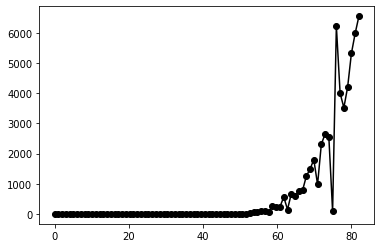

In [108]:
#Analysis of new cases
new_cases = []
indices = list(Italy.index)

for i in range(len(indices)-1):
    new_cases.append(int(Italy.iloc[i+1]['total_cases'])-int(Italy.iloc[i]['total_cases']))
        
new_cases = np.asarray(new_cases)
x_data = np.linspace(0, len(Italy)-1, num=len(Italy)-1)

plt.plot(x_data, new_cases, 
         label='New cases', color='k',marker='o')

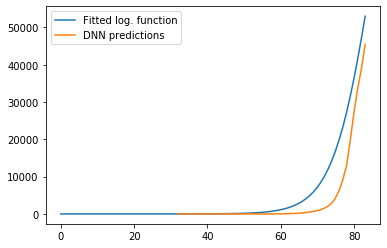

In [109]:
predictions = model_SimpleRNN.predict(x_inputs_RNN) * 60000
x_data = np.linspace(0, len(Italy), num=len(Italy))

plt.plot(x_data, log_func(x_data, params_log[0], params_log[1], params_log[2]),
         label='Fitted log. function')

difference = len(Italy) - len(predictions)

x_data = np.linspace(difference, len(predictions)+difference, num=len(predictions))
plt.plot(x_data, predictions-predictions[0], label="DNN predictions")

plt.legend(loc='best')

In [12]:
def calculate_r2(y, y_fit):
    # residual sum of squares
    ss_res = np.sum((y - y_fit) ** 2)
    
    # total sum of squares
    ss_tot = np.sum((y - np.mean(y)) ** 2)

    # r-squared
    r2 = 1 - (ss_res / ss_tot)

    print(r2)

In [13]:
calculate_r2(Italy['total_cases'],exp_func(x_data, params_exp[0], params_exp[1], params_exp[2]))

0.9969708143573154


In [14]:
calculate_r2(Italy['total_cases'],log_func(x_data, params_log[0], params_log[1], params_log[2]))

0.9988876938561271


In [15]:
def fit_and_plot(country, china_bool=False):

    x_data = np.linspace(0, len(country), num=len(country))

    params_exp = []

    if(china_bool):
        print(params_exp)
    else:
        params_exp, params_covariance_exp = optimize.curve_fit(exp_func, x_data,country['total_cases'],
                                                       p0=[0.1, 0.1, 0.1])
    
    #print(params_exp)
    #print(params_covariance_exp)
    
    params_log, params_covariance_log = optimize.curve_fit(log_func, x_data,country['total_cases'],
                                               p0=[3.0, 0.1, 0.1])

    #print(params_log)
    #print(params_covariance_log)
    
    return params_exp,params_log,x_data

/Users/gunnep/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:795: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


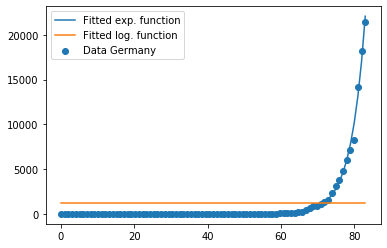

In [16]:
params_exp,params_log,x_data = fit_and_plot(Germany)

plt.figure(figsize=(6, 4))
plt.scatter(x_data, Germany['total_cases'], label='Data Germany')
plt.plot(x_data, exp_func(x_data, params_exp[0], params_exp[1], params_exp[2]),
                 label='Fitted exp. function')

plt.plot(x_data, log_func(x_data, params_log[0], params_log[1], params_log[2]),
                 label='Fitted log. function')

plt.legend(loc='best')

In [17]:
calculate_r2(Germany['total_cases'],exp_func(x_data, params_exp[0], params_exp[1], params_exp[2]))
    
calculate_r2(Germany['total_cases'],log_func(x_data, params_log[0], params_log[1], params_log[2]))

0.9933336552940492
-2.220446049250313e-16


[]


/Users/gunnep/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


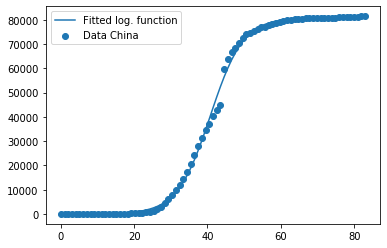

In [18]:
params_exp,params_log,x_data = fit_and_plot(China, True)

plt.figure(figsize=(6, 4))
plt.scatter(x_data, China['total_cases'], label='Data China')

plt.plot(x_data, log_func(x_data, params_log[0], params_log[1], params_log[2]),
                 label='Fitted log. function')

plt.legend(loc='best')

In [19]:
calculate_r2(China['total_cases'],log_func(x_data, params_log[0], params_log[1], params_log[2]))

0.9982729786107419


In [20]:
params_exp,params_log,x_data = fit_and_plot(Korea)

plt.figure(figsize=(6, 4))
plt.scatter(x_data, Korea['total_cases'], label='Data Korea')

plt.plot(x_data, log_func(x_data, params_log[0], params_log[1], params_log[2]),
                 label='Fitted log. function')

plt.plot(x_data, exp_func(x_data, params_exp[0], params_exp[1], params_exp[2]),
                 label='Fitted exp. function')

plt.legend(loc='best')

RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 800.

In [186]:
calculate_r2(Korea['total_cases'],exp_func(x_data, params_exp[0], params_exp[1], params_exp[2]))
    
calculate_r2(Korea['total_cases'],log_func(x_data, params_log[0], params_log[1], params_log[2]))

0.9430237052146274
0.9992102593697357
